# Python for Creating CSV and Preliminary Reporting

In [1]:
import csv
import contextily as cx
import geopandas as gpd
import hvplot.pandas as hpd
import hvplot as hv
import json
import matplotlib.pyplot as plt
import pandas as pd
import rdflib as rdf
from shapely.geometry import Point
import urllib

%matplotlib inline
plt.style.use('ggplot')

from datetime import date
print("Last run: ", date.today())

#gv.extension('bokeh', 'matplotlib')

Last run:  2023-09-23


## Load Data and Write to CSV


In [5]:
with open("roman-amphitheaters.geojson") as f:
    j = json.load(f)

In [6]:
# If there is one, I'd welcome a more pythonic approach. One that 
# accomodates the variable data model supported by JSON.

d = []
for feature in j['features']:
    
    # Check for optional properties

    latintoponym = ''
    if 'latintoponym' in feature['properties'].keys() and type(feature['properties']['latintoponym']) == str:
        latintoponym = feature['properties']['latintoponym']
            
    welchid = ''
    if 'welchid' in feature['properties'].keys():
        welchid = feature['properties']['welchid']
        
    golvinid = ''
    if 'golvinid' in feature['properties'].keys():
        golvinid = feature['properties']['golvinid']

    buildingtype = ''
    if 'buildingtype' in feature['properties'].keys():
        buildingtype = feature['properties']['buildingtype']
            
    try:
        zotero = feature['properties']['bibliography'][0]['zoteroitem']
    except:
        zotero = ''

    amphitheatrum = ''
    if 'amphitheatrum' in feature['properties'].keys():
        amphitheatrum = feature['properties']['amphitheatrum']
 
    chronogroup = ''
    if 'chronogroup' in feature['properties'].keys():
        chronogroup = feature['properties']['chronogroup']
        
    secondcentury = True
    if 'exclude' in feature['properties'].keys():
        secondcentury = False

    capacity = ''
    if 'capacity' in feature['properties'].keys():
        if 'quantity' in feature['properties']['capacity']:
            capacity = feature['properties']['capacity']['quantity']


    romanregion = ''
    if 'province' in feature['properties'].keys():
        romanregion = feature['properties']['province']
    elif 'region' in feature['properties'].keys():
        romanregion = feature['properties']['region']
        
        
    arenamajor = ''
    arenaminor = ''
    extmajor = ''
    extminor = ''
    exteriorheight = ''
    dimensionsunknown = True
    if 'dimensions' in feature['properties'].keys():
        dimensions = feature['properties']['dimensions']
        
        if 'arenamajor' in dimensions:
            if type(dimensions['arenamajor']) == int or type(dimensions['arenamajor']) == float:
                arenamajor = dimensions['arenamajor']
                dimensionsunknown = False

        if 'arenaminor' in dimensions:
            if type(dimensions['arenaminor']) == int or type(dimensions['arenaminor']) == float:
                arenaminor = dimensions['arenaminor']
                dimensionsunknown = False
            
        if 'exteriormajor' in dimensions:
            if type(dimensions['exteriormajor']) == int or type(dimensions['exteriormajor']) == float:
                extmajor = dimensions['exteriormajor']
                dimensionsunknown = False

        if 'exteriorminor' in dimensions:
            if type(dimensions['exteriorminor']) == int or type(dimensions['exteriorminor']) == float:
                extminor = dimensions['exteriorminor']
                dimensionsunknown = False
            
        if 'exteriorheight' in dimensions:
            if type(dimensions['exteriorheight']) == int or type(dimensions['exteriorheight']) == float:
                exteriorheight = dimensions['exteriorheight']
      
    d.append((feature['id'],
              feature['properties']['title'],
              feature['properties']['label'],
              latintoponym,
              feature['properties']['pleiades'],
              welchid,
              golvinid,
              buildingtype,
              chronogroup,
              secondcentury,
              capacity,
              feature['properties']['moderncountry'],
              romanregion,
              zotero,
              amphitheatrum,
              dimensionsunknown,
              arenamajor,
              arenaminor,
              extmajor,
              extminor,
              exteriorheight,
              feature['geometry']['coordinates'][0],
              feature['geometry']['coordinates'][1],
              feature['geometry']['coordinates'][2]))

ramphs_df = pd.DataFrame(d, columns=(
 'id',    # short id
 'title', # longer title
 'label', # short label
 'latintoponym', # latin toponym
 'pleiades', # pleiades https uri
 'welchid',  # id in Welch
 'golvinid', # id in Golvin
 'buildingtype',  # usually 'amphitheater'
 'chronogroup',   # label for the chronological group
 'secondcentury', # is this an amphitheater that was in use in 2nd century
 'capacity',    # capacity as integer
 'modcountry',  # modern country
 'romanregion', # province or augustan region of italy
 'zotero',      # zotero item id
 'amphitheatrum', # amphitheatrum url
 'dimensionsunknown', # if true, that's a direct statement that no dimensions are available
 'arenamajor', # long axis of arena in meters
 'arenaminor', # short axis of arena in meters
 'extmajor',   # long axis of exterior
 'extminor', # short axis of exterior
 'exteriorheight',   # height of exterior wall if known
 'longitude', # longitude
 'latitude', # latitude
 'elevation'  # elevation in meters.
 )) 

ramphs_df[['capacity','elevation','arenamajor','arenaminor',
        'extmajor','extminor','exteriorheight']] = ramphs_df[['capacity','elevation','arenamajor',
        'arenaminor','extmajor','extminor','exteriorheight']].apply(pd.to_numeric)

In [7]:
ramphs_df.to_csv("roman-amphitheaters.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

## Basic Mapping

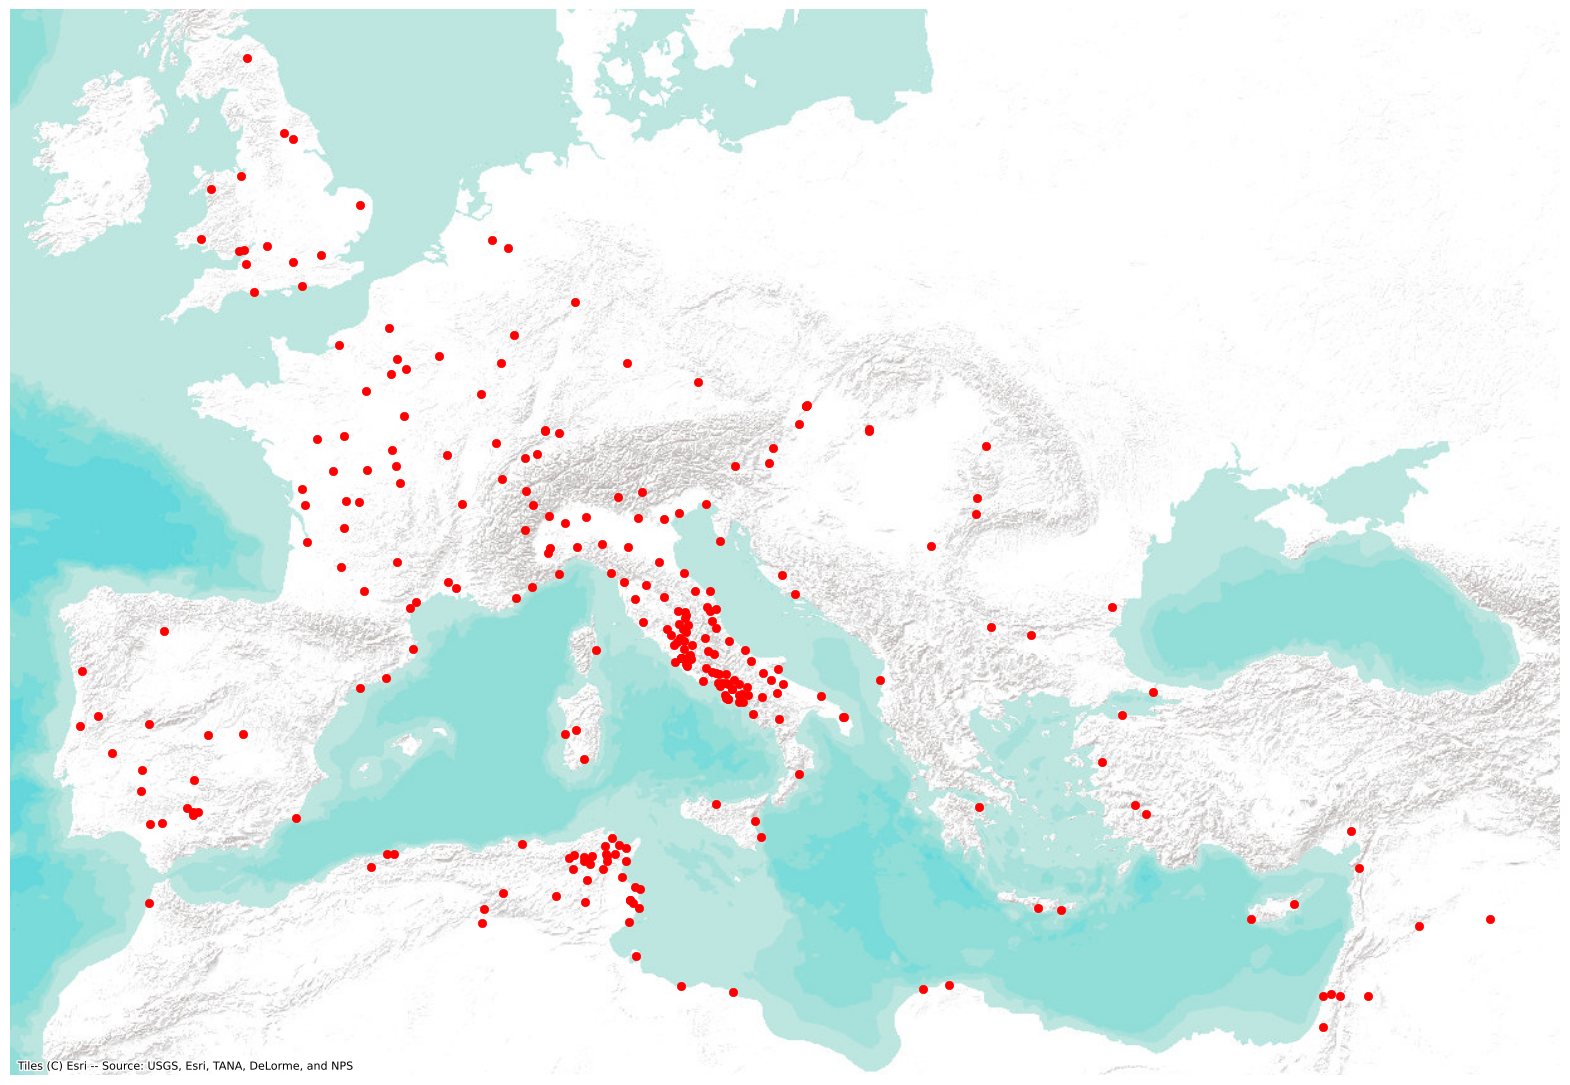

In [8]:
ramphs_gdf = gpd.read_file("roman-amphitheaters.geojson")

ramphs_gdf_epsg3857 = ramphs_gdf.to_crs(3857)

ax = ramphs_gdf_epsg3857.plot(figsize=(20, 20), color = 'red')
cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain)

ax.set_axis_off()
plt.savefig("all-roman-amphitheaters-map.png",pad_inches=0, bbox_inches='tight')

In [14]:
# interactive version
hv = ramphs_gdf.hvplot(global_extent=False,
                          
                           hover_cols = ['id'],
                           tiles='EsriTerrain',
                           xticks = 0, yticks = 0,
                           height = 500,
                           width = 700,
                                c = 'red'
                           )


hv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (id)

In [15]:
# with roman territory using geopandas


url = "http://sebastianheath.com/roman-maps/roman_empire_ad_200_extent.geojson" # at some point update geojson source
borders_gdf = gpd.read_file(url)

base = borders_gdf.plot(color = 'black', figsize = (40,24))
ramphs_gdf.plot(ax = base, color = 'red', markersize = 100)

plt.grid(False)
plt.axis('off')

plt.savefig('all-roman-amphitheaters-map-dark.png',pad_inches=0, bbox_inches='tight', transparent = True)
plt.close()

## Basic/Various Reporting

This is semi-random / redundant code by which I keep on top of data entry...

In [ ]:
ramphs_df.head(2)

In [ ]:
ramphs_df.describe()

In [ ]:
ramphs_df[ramphs_df.secondcentury].describe()

In [ ]:
# Confirm that CSV is readable
# It would be nice if the "numeric pattern" string survived as strings.
pd.read_csv("roman-amphitheaters.csv", quoting = 2).describe()

In [ ]:
# which have heights
ramphs_df[ramphs_df.exteriorheight > 0]

In [ ]:
# which don't have exteriormajor
ramphs_df[pd.isnull(ramphs_df.extmajor)].sort_values(by = 'longitude')\
[['id','modcountry','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

In [ ]:
ramphs_df[ramphs_df.golvinid == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

In [ ]:
ramphs_df[ramphs_df.latintoponym == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

## Duplicate Checking

In [ ]:
dups = ramphs_df[ramphs_df.label.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

In [ ]:
dups = ramphs_df[ramphs_df.id.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

In [ ]:
dups = ramphs_df[ramphs_df.pleiades.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 15

In [ ]:
dups = ramphs_df[ramphs_df.latintoponym.duplicated(keep = False)]\
[['id','pleiades','latintoponym',
  'latitude','longitude']].sort_values('pleiades')

len(dups.query("latintoponym != ''")) == 11

# Chronogrps

In [ ]:
c_grps_from_j = j['romanamphitheaterschronogroups']

In [ ]:
c_grps_to_csv = [[g['id'],g['startdate'],g['enddate']] for g in c_grps_from_j]

In [ ]:
print(f"In c_grps, not in data: {set([i[0] for i in c_grps_to_csv]) - set([i[8] for i in d])}")
print(f"In data, not in c_grps: {set([i[8] for i in d]) - set([i[0] for i in c_grps_to_csv])}")

In [ ]:
if (set([i[0] for i in c_grps_to_csv]) == set([i[8] for i in d])):
    c_grps_df = pd.DataFrame(c_grps_to_csv, columns = ('id','startdate','enddate'))
    c_grps_df.to_csv("chronogrps.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [ ]:
# Provinces (new, incomplete)

# Golvin ID

In [ ]:
L = ramphs_df[ramphs_df['golvinid'] != '']['golvinid'].astype(int).sort_values().tolist()
missingItems = [x for x in list(range(300)) if not x in L]
missingItems

### Dimension/Capacity Combos

In [ ]:
ramphs_df['displaycolor'] = 'red' # problem

ramphs_df.loc[ramphs_df[['capacity']].notnull().all(1),'displaycolor'] = 'purple' # any capacity
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor','capacity']].notnull().all(1),'displaycolor'] = 'green' # 4 dims, cap, complete

ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().any(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'yellow' # any dim, no cap
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().all(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'orange' # 4 dims, no cap

ramphs_df.loc[ramphs_df['dimensionsunknown'] == True,'displaycolor'] = 'black' # no dims, might be a cap 'nazili'

# this should be False
print('red' in list(ramphs_df.displaycolor.unique()))

bar_series = ramphs_df['displaycolor'].value_counts()

bar_series.index = ramphs_df['displaycolor'].value_counts()


bar_series.plot.bar(color = ramphs_df['displaycolor'].value_counts().index, xlabel = '')

In [ ]:
# 4 dims, no 3rd party capacity estimate yet entered
all_ok = ['allifaeAmphitheater','altinumAmphitheater','anazarbusAmphitheater','avellaAmphitheater',
          'burnumAmphitheater', 'carmarthenAmphitheater',
          'cherchellAmphitheater','larinoAmphitheater','leonAmphitheater',
          'porolissumAmphitheater', 'narbonneAmphitheater','tharrosAmphitheater']

ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']]\
              .notnull().all(1) & ramphs_df['capacity'].isnull()\
              ,['id','golvinid','capacity','dimensionsunknown']]\
              .set_index('id', drop=False)\
              .drop(all_ok)# .hvplot.table(sortable=True, selectable=True)


In [ ]:
# fewer than 4 dims, capacity recorded
ramphs_df.loc[ramphs_df['displaycolor'] == 'purple'\
              ,['id','golvinid','capacity','dimensionsunknown','extmajor','extminor','arenamajor','arenaminor']]\
            .hvplot.table(sortable=True, selectable=True)


In [ ]:
# any dim, no cap
# ok_to_drop

ramphs_df.loc[ramphs_df['displaycolor'] == 'yellow'\
              ,['id','golvinid','capacity','dimensionsunknown','extmajor','extminor','arenamajor','arenaminor']]\
            .hvplot.table(sortable=True, selectable=True)